## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
n_records = data.shape[0]
print("Рядки:", n_records)

Рядки: 891


In [4]:
survived = data['Survived'].value_counts()
print(survived)

0    549
1    342
Name: Survived, dtype: int64


Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [5]:
without_missing_age = data.dropna(subset = ['Age'])
without_missing_age = without_missing_age.reset_index(drop=True)
without_missing_age.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
n_records = without_missing_age.shape[0]
print("Кількість записів:", n_records)

Кількість записів: 714


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

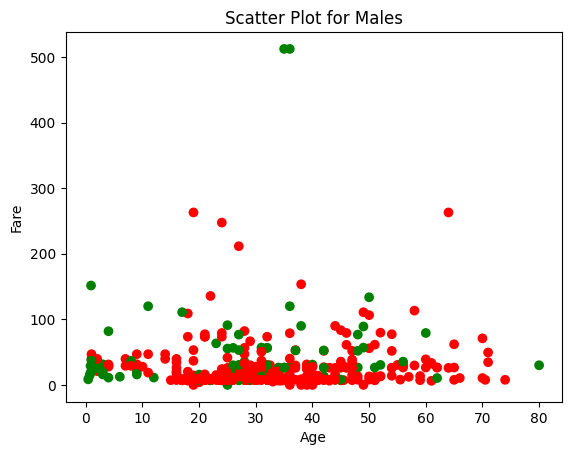

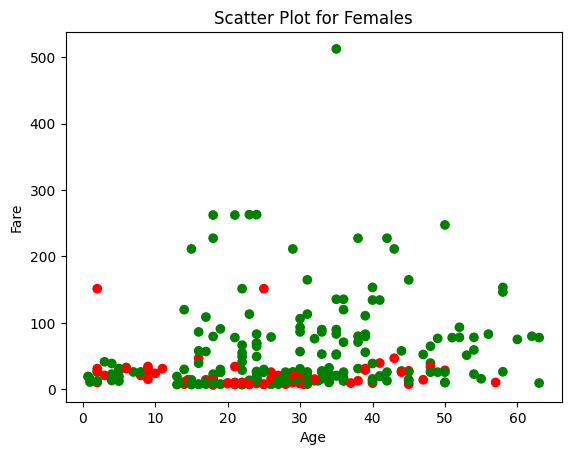

In [8]:
male_data = without_missing_age[without_missing_age['Sex'] == 'male']
female_data = without_missing_age[without_missing_age['Sex'] == 'female']

plt.scatter(male_data['Age'], male_data['Fare'], c=male_data['Survived'].map({0: 'red', 1: 'green'}))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Scatter Plot for Males')
plt.show()

plt.scatter(female_data['Age'], female_data['Fare'], c=female_data['Survived'].map({0: 'red', 1: 'green'}))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Scatter Plot for Females')
plt.show()

In [ ]:
# место для кода

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [9]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [10]:
import numpy as np
import tqdm

In [11]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [14]:

# Суммарная точность классификации
accuracy = 0
for idx, row in tqdm.tqdm(without_missing_age.iterrows(), total=len(without_missing_age)):
    accuracy += row['Survived'] == myKNeighborsClassifier(without_missing_age, 5, idx)
print(accuracy/without_missing_age.shape[0])

100%|██████████| 714/714 [03:12<00:00,  3.71it/s]

0.726890756302521


Этот код вычисляет точность предсказания, сравнивая фактический статус спасения пассажира с предсказанным результатом для каждой строки without_missing_age. В конце, он делит суммарную точность на общее количество пассажиров для получения итоговой точности (accuracy).

Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

In [19]:
best_accuracy = 0
best_K = 0

for K in range(1, 11):
  accuracy = 0

  for idx, row in tqdm.tqdm(without_missing_age.iterrows(), total=len(without_missing_age)):
    accuracy += row['Survived'] == myKNeighborsClassifier(without_missing_age, K, idx)

  accuracy /=len(without_missing_age)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_K = K

print("Найкраща якість класифікації:", best_accuracy)
print("Оптимальне K:", best_K)

100%|██████████| 714/714 [02:40<00:00,  4.46it/s]

Найкраща якість класифікації: 0.7366946778711485
Оптимальне K: 9


Этот код выполняет цикл по значениям K от 1 до 10. Внутри вложенного цикла он вычисляет точность классификации для каждого пассажира в without_missing_age и суммирует количество правильных предсказаний. Затем он делит сумму на общее количество пассажиров для получения точности классификации. Если текущая точность классификации превышает лучшую точность, она обновляется, и соответствующее значение K сохраняется.

В конце код выводит наилучшую точность классификации и оптимальное значение K.


## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [20]:
import numpy as np

def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  # LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key=lambda pair: pair[0])
    margin = 0
    for i in range(K):
        margin += dists[i][1]
    margin /= K
    return margin

margins = []

for idx, row in tqdm.tqdm(without_missing_age.iterrows(), total=len(without_missing_age)):
    margin = calcMargin(without_missing_age, best_K, idx)
    margins.append(margin)

margins = np.array(margins)
idx = np.argsort(margins)

print('Пять объектов с минимальным выступом (шумовые выбросы):')
print(without_missing_age.loc[idx[:5]])
print('\nПять объектов с максимальным выступом (эталоны):')
print(without_missing_age.loc[idx[-5:]])


100%|██████████| 714/714 [02:02<00:00,  5.83it/s]

Пять объектов с минимальным выступом (шумовые выбросы):
     PassengerId  Survived  Pclass                                Name   Sex  \
0              1         0       3             Braund, Mr. Owen Harris  male   
170          213         0       3              Perkin, Mr. John Henry  male   
577          726         0       3                 Oreskovic, Mr. Luka  male   
665          834         0       3              Augustsson, Mr. Albert  male   
44            60         0       3  Goodwin, Master. William Frederick  male   

      Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0    22.0      1      0  A/5 21171   7.2500   NaN        S  
170  22.0      0      0  A/5 21174   7.2500   NaN        S  
577  20.0      0      0     315094   8.6625   NaN        S  
665  23.0      0      0     347468   7.8542   NaN        S  
44   11.0      5      2    CA 2144  46.9000   NaN        S  

Пять объектов с максимальным выступом (эталоны):
     PassengerId  Survived  Pclass  \
235      

В этом коде добавлена функция calcMargin, которая вычисляет выступ объекта на основе метода k ближайших соседей. В основном цикле мы вычисляем выступы для каждого объекта в without_missing_age и сохраняем их в массив margins. Затем мы сортируем массив margins и используем индексы, возвращенные функцией np.argsort, для извлечения информации о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах).

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [ ]:
idx = np.argsort(margins)

In [ ]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

In [ ]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]